<a href="https://colab.research.google.com/github/marcolussetti/opendotadump-tools/blob/master/analysis/heroes_picks/LookupSpikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Hero Picks
This notebook will produce graphs of the heroes picked on a per-day basis.

## Processing

### Imports & Configuration

In [1]:
# Update pandas, just in case
!pip install pandas -U

# If plotnine is not installed:
!pip install plotnine

# If using on google colab, might need to update statsmodels version
!pip install statsmodels -U

# If not installed
!pip install requests

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.24.2)
Requirement already up-to-date: statsmodels in /usr/local/lib/python3.6/dist-packages (0.9.0)


### Constants for configuration

In [0]:
CSV_INPUT_FILE = "https://raw.githubusercontent.com/marcolussetti/processopendota/master/data/heroes_picks_csvs/stable-picks_heroes-names_normalized.csv"
OPENDOTA_API_HEROES_ENDPOINT = "https://api.opendota.com/api/heroes/"

In [0]:
import pandas as pd
import requests
from plotnine import *
from scipy.spatial import distance
from datetime import datetime, timedelta

In [0]:
%matplotlib inline

### Import data

In [0]:
# Load input csv
df = pd.read_csv(CSV_INPUT_FILE, index_col=0)

### Examine the data

#### Overall heroes  metrics

In [0]:
# Most popular heroes overall (mean)
heroes_most_popular = df.mean().sort_values(ascending=False)[:10]  # Average of normalized pick frequency

# Heroes with the most variation
heroes_most_variation = df.std().sort_values(ascending=False)[:15]  # Standard deviation of pick frequency

# Heroes with the least variation
heroes_least_variation = df.std().sort_values(ascending=False)[:10]  # Standard deviation of pick frequency

#### Reformat data for "easy" graphing

In [0]:
df_expl_graph = df.copy(deep=True)
# Condense values
df_expl_graph = df_expl_graph.stack()
df_expl_graph = df_expl_graph.reset_index()

df_expl_graph.columns = ["Day", "Hero", "Frequency"]

df_expl_graph["Day"] = df_expl_graph["Day"].apply(pd.to_datetime)

df_expl_graph["Week"] = df_expl_graph["Day"].apply(lambda date: "{}-{}".format(date.year,date.week))
df_expl_graph["Month"] = df_expl_graph["Day"].apply(lambda date: "{}-{}".format(date.year,date.month))
df_expl_graph["Year"] = df_expl_graph["Day"].apply(lambda date: date.year)


In [0]:
df_most_popular_graph = df_expl_graph[df_expl_graph["Hero"].isin(heroes_most_popular.keys())]
df_most_variation_graph = df_expl_graph[df_expl_graph["Hero"].isin(heroes_most_variation.keys())]

#### Graphs (ignore)

In [0]:
all_day_plot = (ggplot(df_expl_graph, aes(x="Day", y="Frequency", color="Hero", group=1))
              +geom_point()
             )
# all_day_plot
# all_day_plot.save("all_day_plot.png", width=40, height=32, dpi=300, limitsize=False)

In [0]:
all_day_stacked_plot = (ggplot(df_expl_graph, aes(x="Day", y="Frequency"))
              +geom_area(aes(fill="Hero"))
             )
# all_day_stacked_plot
# all_day_stacked_plot.save("all_day_stacked_plot.png", width=44, height=12, dpi=300, limitsize=False)

#### Detect changes over time

In [0]:
def previous_distribution_vector(df, date_start, date_end, average_function="mean"):
  df_filtered = df[(df["Day"] >= date_start) & (df["Day"] < date_end)]
  
  if average_function == "median":
    result = df_filtered.groupby(["Hero"]).median()[["Frequency"]]
  else:
    result = df_filtered.groupby(["Hero"]).mean()[["Frequency"]]
  
  return result.to_dict()["Frequency"]

def compute_distance(day, previous_period_average, distance_function=distance.euclidean, weighted=False):
  previous = [value for key, value 
              in sorted(previous_period_average.items(), key=lambda x: x[0])]
  current = [value for key, value 
              in sorted(day.items(), key=lambda x: x[0])]
  assert len(previous) == len(current), "Incorrect length: previous-> {}, current-> {}".format(len(previous), len(current))
  if weighted:
    return distance_function(previous, current, previous)
  else:
    return distance_function(previous, current)
  
def day_difference(df, day, distance_function=distance.euclidean, length=14, average_function="mean", weighted=False):
  # Extract vector for day
  day_picks = {record["Hero"]: record["Frequency"] for record 
               in df[df["Day"] == day][["Hero", "Frequency"]].to_dict('records')
              }
  previous_picks = previous_distribution_vector(df, datetime.strptime(day, '%Y-%m-%d') - timedelta(days=length), day, average_function)
  
  return compute_distance(day_picks, previous_picks, distance_function, weighted)

def all_days_difference(df, distance_function=distance.euclidean, length=14, average_function="mean", weighted=False):
  all_days = [str(d) for d in sorted(set(date.date() for key, date in df["Day"].to_dict().items()))[1:]]
  
  return {day: day_difference(
      df, day, distance_function=distance_function, 
      length=length, average_function="mean") 
   for day in all_days}

#### Graph differences (ignore)

In [0]:
# Try to graph differences for top 10 champions by popularity
pop_differences_by_day = all_days_difference(df_most_popular_graph).items()
sorted_pop_differences_by_day = sorted(pop_differences_by_day, key=lambda x: x[1], reverse=True)
df_pop_differences_by_day = pd.DataFrame(pop_differences_by_day)
df_pop_differences_by_day.columns = ["Day", "Difference"]

popular_heroes_differences_plot = (
    ggplot(df_pop_differences_by_day, aes(x="Day", y="Difference", color="Difference"))
    +geom_point()
    +geom_area(aes(fill="Difference"))
)

# popular_heroes_differences_plot
# popular_heroes_differences_plot.save("pop_differences_plot.png", width=44, height=5, dpi=300, limitsize=False)

In [0]:
# Try to graph differences for all heroes

all_differences_by_day = all_days_difference(df_expl_graph).items()
sorted_all_differences_by_day = sorted(all_differences_by_day, key=lambda x: x[1], reverse=True)
df_all_differences_by_day = pd.DataFrame(all_differences_by_day)
df_all_differences_by_day.columns = ["Day", "Difference"]
df_all_differences_by_day.head()

all_heroes_differences_plot = (
    ggplot(df_all_differences_by_day, aes(x="Day", y="Difference", color="Difference"))
    +geom_point()
    +geom_area(aes(fill="Difference"))
)

# all_heroes_differences_plot
# all_heroes_differences_plot.save("all_differences_plot.png", width=44, height=5, dpi=300, limitsize=False)

In [0]:
# What if we weight it?
# Try to graph differences for all heroes

all_differences_by_day_weighted = all_days_difference(df_expl_graph, weighted=True).items()
sorted_all_differences_by_day_weighted = sorted(all_differences_by_day_weighted, key=lambda x: x[1], reverse=True)
df_all_differences_by_day_weighted = pd.DataFrame(all_differences_by_day_weighted)
df_all_differences_by_day_weighted.columns = ["Day", "Difference"]
df_all_differences_by_day_weighted.head()

all_heroes_differences_weighted_plot = (
    ggplot(df_all_differences_by_day_weighted, aes(x="Day", y="Difference", color="Difference"))
    +geom_point()
    +geom_area(aes(fill="Difference"))
)

# all_heroes_differences_weighted_plot
# all_heroes_differences_plot.save("all_differences_weighted_plot.png", width=44, height=5, dpi=300, limitsize=False)

In [0]:
# Try to graph differences for all heroes, 28 days

all_differences_by_day_28 = all_days_difference(df_expl_graph, length=28).items()
sorted_all_differences_by_day_28 = sorted(all_differences_by_day_28, key=lambda x: x[1], reverse=True)
df_all_differences_by_day_28 = pd.DataFrame(all_differences_by_day_28)
df_all_differences_by_day_28.columns = ["Day", "Difference"]
df_all_differences_by_day_28.head()

all_differences_by_day_28_plot = (
    ggplot(df_all_differences_by_day_28, aes(x="Day", y="Difference", color="Difference"))
    +geom_point()
    +geom_area(aes(fill="Difference"))
)

# all_differences_by_day_28_plot
# all_differences_by_day_28_plot.save("all_differences_28_plot.png", width=44, height=5, dpi=300, limitsize=False)

In [0]:
# Try to graph differences for all heroes, manhattan distance

all_differences_by_day_manhattan = all_days_difference(df_expl_graph, distance_function=distance.cityblock).items()
sorted_all_differences_by_day_manhattan = sorted(all_differences_by_day_manhattan, key=lambda x: x[1], reverse=True)
df_all_differences_by_day_manhattan = pd.DataFrame(all_differences_by_day_manhattan)
df_all_differences_by_day_manhattan.columns = ["Day", "Difference"]

all_heroes_differences_manhattan_plot = (
    ggplot(df_all_differences_by_day_manhattan, aes(x="Day", y="Difference", color="Difference"))
    +geom_point()
    +geom_area(aes(fill="Difference"))
)

# all_heroes_differences_manhattan_plot
# all_heroes_differences_manhattan_plot.save("all_differences_manhattan_plot.png", width=44, height=5, dpi=300, limitsize=False)

## Poster graphs (ignore)

### Pick rates by hero (stacked) graph

In [0]:
poster_stacked = (
    ggplot(df_expl_graph, aes(x="Day", y="Frequency"))
    +geom_area(aes(fill="Hero"), color="white")
    +guides(fill=guide_legend(ncol=3, title="Heroes"))
    +scale_x_datetime(date_breaks="6 months", minor_breaks=4, limits=["2012-01-01", "2016-01-01"])
    +ggtitle("Heroes Pick Rates (2011-11-22 - 2016-04-23)")
    +xlab("")
    +ylab("Pick Rate")
    +theme(
        text=element_text(family=['serif']),
        axis_text=element_text(size=24.0),
        #axis_text_x=element_text(ha="right"),
        axis_title_y=element_text(size=36.0),
        axis_title_x=element_text(size=0.0),
        legend_title=element_blank(),
        plot_title=element_text(size=72.0),
        axis_text_x=element_text(size=18.0, family=['Dejavu Sans', 'Dejavu']),#, angle=45),
        panel_background=element_rect(fill="white", colour="white"),
    )
)
# poster_stacked
poster_stacked.save("poster_stacked_white_46x12.png", width=46, height=12, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 46 x 12 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: poster_stacked_white_46x12.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:430: UserWarning: position_stack : Removed 16872 rows containing missing values.
  data = self.position.setup_data(self.data, params)
/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


### Difference graph

In [0]:
poster_differences_plot = (
    ggplot(df_all_differences_by_day_manhattan, aes(x="Day", y="Difference", color="Difference"))
    +geom_point()
    +geom_area(aes(fill="Difference"))
    +scale_color_gradient(low="#5D5DA9", high="#DC5657")
    +scale_fill_gradient(low="#5D5DA9", high="#DC5657")
    +scale_x_datetime(date_breaks="6 months", minor_breaks=4, limits=["2012-01-01", "2016-01-01"])
    +xlab("")
    +theme(
        text=element_text(family=['serif']),
        panel_background=element_rect(fill="white", colour="white"),
        panel_grid=element_blank(),
        axis_text=element_text(size=24.0),
        axis_title_y=element_text(size=36.0),
        axis_title_x=element_text(size=0.0),
        axis_text_x=element_text(size=18.0, family=['Dejavu Sans', 'Dejavu']),
        legend_text=element_text(family=['Dejavu Sans', 'Dejavu']),
        legend_title=element_blank(),
    )
)

# poster_differences_plot
poster_differences_plot.save("poster_differences_white_41x5.png", width=41, height=5, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 41 x 5 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: poster_differences_white_41x5o.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:430: UserWarning: position_stack : Removed 151 rows containing missing values.
  data = self.position.setup_data(self.data, params)
/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 151 rows containin

#### Differences graph (3mo)

In [0]:
poster_differences_plot_3mo = (
    ggplot(df_all_differences_by_day_manhattan, aes(x="Day", y="Difference", color="Difference"))
    +geom_point()
    +geom_area(aes(fill="Difference"))
    +scale_color_gradient(low="#5D5DA9", high="#DC5657")
    +scale_fill_gradient(low="#5D5DA9", high="#DC5657")
    +scale_x_datetime(date_breaks="3 months", minor_breaks=4, limits=["2012-01-01", "2016-01-01"])
    +xlab("")
    +theme(
        text=element_text(family=['serif']),
        panel_background=element_rect(fill="white", colour="white"),
        panel_grid=element_blank(),
        axis_text=element_text(size=24.0),
        axis_title_y=element_text(size=36.0),
        axis_title_x=element_text(size=0.0),
        axis_text_x=element_text(size=18.0, family=['Dejavu Sans', 'Dejavu']),
        legend_text=element_text(family=['Dejavu Sans', 'Dejavu']),
        legend_title=element_blank(),
    )
)

poster_differences_plot_3mo.save("poster_differences_white_41x5_3mo.png", width=41, height=5, dpi=300, limitsize=False)

## Explore differences

In [104]:
# Try to graph differences for all heroes, manhattan distance

all_differences_by_day_manhattan = all_days_difference(df_expl_graph, distance_function=distance.cityblock).items()
differences_by_day_manhattan = all_days_difference(df_expl_graph, distance_function=distance.cityblock)
sorted_all_differences_by_day_manhattan = sorted(all_differences_by_day_manhattan, key=lambda x: x[1], reverse=True)
df_all_differences_by_day_manhattan = pd.DataFrame(all_differences_by_day_manhattan)
df_all_differences_by_day_manhattan.columns = ["Day", "Difference"]

TypeError: ignored

In [0]:
top_differences = {record[0]: {"order": i + 1, "value": record[1]} for i, record in list(enumerate(sorted_all_differences_by_day_manhattan))}

In [92]:
all_differences_by_day_manhattan

dict_items([('2011-11-24', 0.03102769564943588), ('2011-11-25', 0.02914068632612857), ('2011-11-26', 0.03189925284428599), ('2011-11-27', 0.02475901013102568), ('2011-11-28', 0.02712161610759594), ('2011-11-29', 0.0245123233567446), ('2011-11-30', 0.024415113048680638), ('2011-12-01', 0.12288137368393812), ('2011-12-02', 0.07141451618909293), ('2011-12-03', 0.05319640132911632), ('2011-12-04', 0.04156036619175575), ('2011-12-05', 0.04233328008034183), ('2011-12-06', 0.03817790242240243), ('2011-12-07', 0.03717257256869404), ('2011-12-08', 0.10752905900026624), ('2011-12-09', 0.06417531574753446), ('2011-12-10', 0.054343954446708226), ('2011-12-11', 0.04976656234397786), ('2011-12-12', 0.04243466352251925), ('2011-12-13', 0.048095183705926844), ('2011-12-14', 0.04688130786664927), ('2011-12-15', 0.07718109053042893), ('2011-12-16', 0.13122976887096807), ('2011-12-17', 0.07285845592526176), ('2011-12-18', 0.05972618627539225), ('2011-12-19', 0.04527975158735657), ('2011-12-20', 0.0357020

In [41]:
top_differences["2015-04-30"]

{'order': 74, 'value': 0.15651667467360603}

In [0]:
top_differences

## Printout Graphs

### Most Popular

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:430: UserWarning: position_stack : Removed 1520 rows containing missing values.
  data = self.position.setup_data(self.data, params)
/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


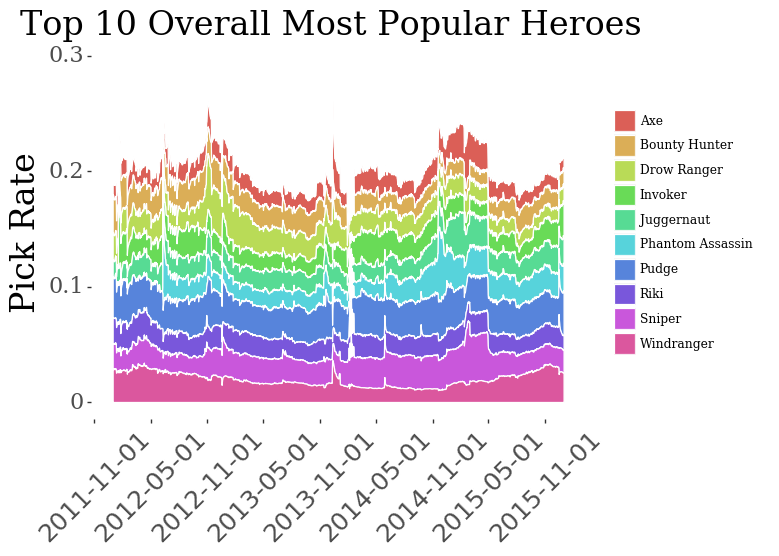

<ggplot: (-9223363300260838901)>

In [20]:
poster_stacked = (
    ggplot(df_most_popular_graph, aes(x="Day", y="Frequency"))
    +geom_area(aes(fill="Hero"), color="white")
    +guides(fill=guide_legend(ncol=1, title="Heroes"))
    +scale_x_datetime(date_breaks="6 months", minor_breaks=4, limits=["2012-01-01", "2016-01-01"])
    +ggtitle("Top 10 Overall Most Popular Heroes")
    +xlab("")
    +ylab("Pick Rate")
    +theme(
        text=element_text(family=['serif']),
        axis_text=element_text(size=16.0),
        #axis_text_x=element_text(ha="right"),
        axis_title_y=element_text(size=24.0),
        axis_title_x=element_text(size=0.0),
        legend_title=element_blank(),
        plot_title=element_text(size=24.0),
        axis_text_x=element_text(size=18.0, family=['Dejavu Sans', 'Dejavu'], angle=45),
        panel_background=element_rect(fill="white", colour="white"),
    )
)

poster_stacked

In [21]:
# poster_stacked
poster_stacked.save("printout_most_popular_cumulative_15x4_5.png", width=15, height=4.5, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 15 x 4.5 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: printout_most_popular_cumulative_15x4_5.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:430: UserWarning: position_stack : Removed 1520 rows containing missing values.
  data = self.position.setup_data(self.data, params)
/usr/local/lib/python3.6/dist-packages/plotnine/positions/position_stack.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data = pd.concat([neg, pos], axis=0, ignore_index=True)


/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 1520 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


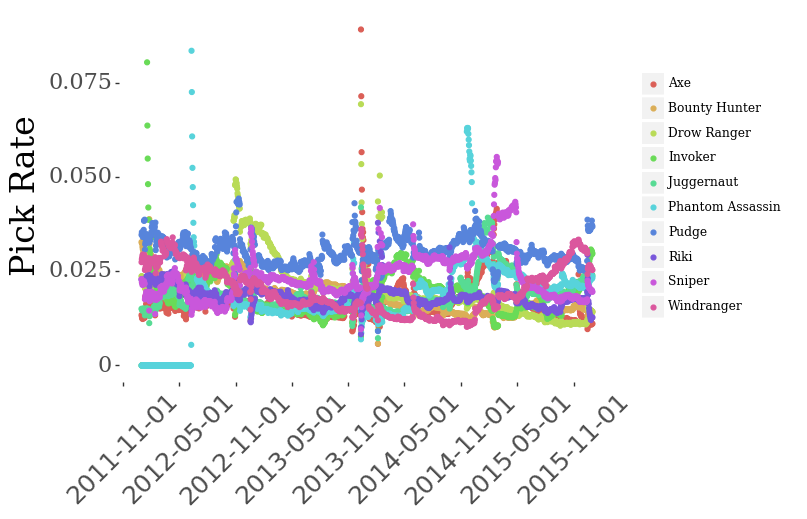

<ggplot: (8736594660879)>

In [24]:
poster_stacked = (
    ggplot(df_most_popular_graph, aes(x="Day", y="Frequency"))
    +geom_point(aes(color="Hero"))
    +guides(color=guide_legend(ncol=1, title="Heroes"))
    +scale_x_datetime(date_breaks="6 months", minor_breaks=4, limits=["2012-01-01", "2016-01-01"])
    #+ggtitle("Most PopulHeroes Pick Rates (2011-11-22 - 2016-04-23)")
    +xlab("")
    +ylab("Pick Rate")
    +theme(
        text=element_text(family=['serif']),
        axis_text=element_text(size=16.0),
        #axis_text_x=element_text(ha="right"),
        axis_title_y=element_text(size=24.0),
        axis_title_x=element_text(size=0.0),
        legend_title=element_blank(),
        plot_title=element_text(size=24.0),
        axis_text_x=element_text(size=18.0, family=['Dejavu Sans', 'Dejavu'], angle=45),
        panel_background=element_rect(fill="white", colour="white"),
    )
)

poster_stacked

In [25]:
# poster_stacked
poster_stacked.save("printout_most_popular_point_15x4_5.png", width=15, height=4.5, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 15 x 4.5 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: printout_most_popular_point_15x4_5.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 1520 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


### Most variation

/usr/local/lib/python3.6/dist-packages/plotnine/geoms/geom_path.py:74: UserWarning: geom_path: Removed 152 rows containing missing values.
  warn(msg.format(n1-n2))


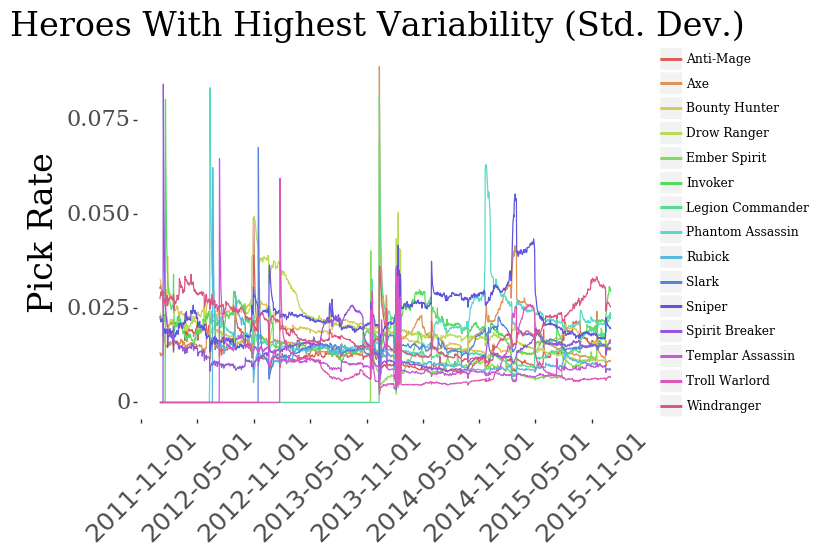

<ggplot: (-9223363300259835192)>

In [33]:

poster_stacked = (
    ggplot(df_most_variation_graph, aes(x="Day", y="Frequency"))
    +geom_line(aes(color="Hero"))
    +guides(color=guide_legend(ncol=1, title="Heroes"))
    +scale_x_datetime(date_breaks="6 months", minor_breaks=4, limits=["2012-01-01", "2016-01-01"])
    +ggtitle("Heroes With Highest Variability (Std. Dev.)")
    +xlab("")
    +ylab("Pick Rate")
    +theme(
        text=element_text(family=['serif']),
        axis_text=element_text(size=16.0),
        #axis_text_x=element_text(ha="right"),
        axis_title_y=element_text(size=24.0),
        axis_title_x=element_text(size=0.0),
        legend_title=element_blank(),
        plot_title=element_text(size=24.0),
        axis_text_x=element_text(size=18.0, family=['Dejavu Sans', 'Dejavu'], angle=45),
        panel_background=element_rect(fill="white", colour="white"),
    )
)

poster_stacked

In [34]:
# poster_stacked
poster_stacked.save("printout_most_variation_line_15x4_5.png", width=15, height=4.5, dpi=300, limitsize=False)

/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:706: UserWarning: Saving 15 x 4.5 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.6/dist-packages/plotnine/ggplot.py:707: UserWarning: Filename: printout_most_variation_line_15x4_5.png
  warn('Filename: {}'.format(filename))
/usr/local/lib/python3.6/dist-packages/plotnine/geoms/geom_path.py:74: UserWarning: geom_path: Removed 152 rows containing missing values.
  warn(msg.format(n1-n2))


## Printout Tables

In [0]:
KEY_DATES = [
    "2012-01-12", "2012-06-11", "2012-07-26", 
    "2012-10-30", "2012-12-19", "2013-11-14", 
    "2013-12-12", "2014-01-19", "2014-02-05", 
    "2014-11-20", "2015-02-18", "2015-04-30", 
    "2015-05-03", "2015-09-25", "2015-12-16"
]

In [0]:
heroes = [hero for hero in df_expl_graph["Hero"]]

In [0]:
two_week_averages = {date: previous_distribution_vector(df_expl_graph, datetime.strptime(date, '%Y-%m-%d') - timedelta(days=14), date, average_function="mean") for date in KEY_DATES}

In [0]:
day_average = {date: {row["Hero"]: row["Frequency"] for id, row in df_expl_graph[df_expl_graph["Day"] == date][["Hero", "Frequency"]].iterrows()} for date in KEY_DATES}

In [0]:
day_difference = {date: {hero: abs(frequency - two_week_averages[date][hero]) for hero, frequency in day_average[date].items()} for date in KEY_DATES}

In [0]:
day_difference_top_10 = {date: (sorted(list(differences.items()), key=lambda x: x[1], reverse=True)[:10]) for date, differences in day_difference.items()}

In [0]:
def process_differences(date, differences):
  results = [("Hero", "Portion of day's shift", "Manhattan distance",
              "Pick for day", "Average pick for 14 prev day")]
  
  total_day_difference = dict(all_differences_by_day_manhattan)[date]
#   for hero in heroes:
#     if hero in [hero in differences] or hero in two_week_averages.keys():
#       results.append((
#           hero,
#           differences[hero] / total_day_difference,
#           differences[hero],
#           day_average[date][hero],
#           two_week_averages[date][hero]
#       ))
  
  for hero, difference in differences:
    results.append((
        hero,
        difference / total_day_difference,
        difference,
        day_average[date][hero],
        two_week_averages[date][hero]
    ))
  
  return results

In [129]:
top_10_differences_by_day = {day: process_differences(day, differences) for day, differences in day_difference_top_10.items()}

TypeError: ignored

In [128]:
top_10_differences_by_day

{'2012-01-12': [('Hero',
   "Portion of day's shift",
   'Manhattan distance',
   'Pick for day',
   'Average pick for 14 prev day'),
  ('Spirit Breaker',
   0.2633107734277672,
   0.0843867958459692,
   0.0843867958459692,
   0.0),
  ('Silencer',
   0.2079527814010941,
   0.06664546490540607,
   0.06664546490540607,
   0.0),
  ('Axe',
   0.02655372525082523,
   0.008510034597221102,
   0.021379704614033296,
   0.012869670016812194),
  ('Anti-Mage',
   0.023577701694288706,
   0.007556267726884003,
   0.022807037470327005,
   0.030363305197211008),
  ('Earthshaker',
   0.017963079655045167,
   0.005756873203029098,
   0.015303128395594575,
   0.021060001598623673),
  ('Pudge',
   0.016122750149310226,
   0.005167077699153255,
   0.030685763395916388,
   0.03585284109506964),
  ('Tidehunter',
   0.015376961463072358,
   0.004928064624258873,
   0.016094408414070397,
   0.02102247303832927),
  ('Night Stalker',
   0.015185116104709042,
   0.0048665813249640835,
   0.015333416625966855,
 

In [0]:
# Write to CSV-ish
with open("explain.csv", "w") as f:
  for date, rows in top_10_differences_by_day.items():
    date_row = (date, "Position: {}".format(top_differences[date]["order"]), "Shift: {}".format(dict(all_differences_by_day_manhattan)[date]))
    for date_component in date_row:
      f.write(date_component)
      f.write(",")
    f.write("\n")
    for row in rows:
      for item in row:
        f.write(str(item))
        f.write(",")
      f.write("\n")